# Binary Classification: are this two documents from the same desafio?

Objectivos:

        Evaluar la capacidad de un modelo de identificar si dos documentos provienen del mismo desafio.

        Con esto, aumentar la validez y coherencia interna de todo el proyecto.

### Preprocess

In [2]:
path_to_MyModule = '..'

import sys
sys.path.insert(0, path_to_MyModule) 

import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier

from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from MyModule.GeneralFunctions import *
from MyModule.SummarizationFunctions import *
from MyModule.SamplingFunctions import *

In [3]:
df = pd.read_excel('..\datos.xlsx')[['ID','texto','desafio']]

In [4]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

df.reset_index(inplace=True, drop=True)

### Create target variable: 
True if the pair comes from the same desafio, false otherwise

In [5]:
# Create a list of tuples containing all possible pairs of strings and ID's
import itertools
id_pairs = list(itertools.combinations(df['ID'].values, 2))

In [6]:
# Create target: 1 if both ID's are from the same desafio, 0 otherwise
target = []
for id1, id2 in id_pairs:
    for desafio in df['desafio'].unique():
        ids_desafio = df[df['desafio']==desafio]['ID'].values
        if id1 in ids_desafio and id2 in ids_desafio:
            target.append(1)
            break
        elif id1 in ids_desafio or id2 in ids_desafio:
            target.append(0)
            break

In [7]:
df_predic = pd.DataFrame([id_pairs, target]).T
df_predic.columns = ['id_pairs','target']

# Are this two ideas from the same desafio?

## Sentence embedding feature

Create a sentence embedding for each document

Alternatives:

1. One column for each of the 768 D
2. Same but first reduce dimension with PCA or Lasso/Ridge

In [8]:
model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')

In [9]:
original_documents = df['texto'].values

pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

pp_documents = pp_object.preprocess(original_documents)

emb_docs = model.encode(pp_documents)

In [10]:
# Add as featrues the document vectors for each document in the pair

first_doc_emb = []
second_doc_emb = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    indice_pair1 = df[df['ID']==pair1].index[0]
    first_doc_emb.append(emb_docs[indice_pair1])
    
    indice_pair2 = df[df['ID']==pair2].index[0]
    second_doc_emb.append(emb_docs[indice_pair2])
    

# create dataframe
df_emb_1 = pd.DataFrame(first_doc_emb)
df_emb_2 = pd.DataFrame(second_doc_emb)

# rename columns
df_emb_1.columns = [f'first_doc_emb_dim_{i+1}' for i in range(len(first_doc_emb[0]))]
df_emb_2.columns = [f'second_doc_emb_dim_{i+1}' for i in range(len(second_doc_emb[0]))]
df_emb = df_emb_1.join(df_emb_2)

# join with main df
df_predic = df_predic.join(df_emb)

## Sentiment Analysis feature

Evaluate positive, negative and neutral sentiment for each document

In [11]:
# Analyze the three sentiments for each doc
from MyModule.SentimentAnalysisFunctions import sentiment_analyzer_3d

all_emotions = {}
analyzer = sentiment_analyzer_3d()

for i, this_id in enumerate(df['ID'].values):
    # print('Doing {} of {}'.format(i, len(df['ID'].values)))
    all_emotions[this_id] = analyzer.predict_sentiment_3d(pp_documents[i])

Doing 0 of 505
Doing 1 of 505
Doing 2 of 505
Doing 3 of 505
Doing 4 of 505
Doing 5 of 505
Doing 6 of 505
Doing 7 of 505
Doing 8 of 505
Doing 9 of 505
Doing 10 of 505
Doing 11 of 505
Doing 12 of 505
Doing 13 of 505
Doing 14 of 505
Doing 15 of 505
Doing 16 of 505
Doing 17 of 505
Doing 18 of 505
Doing 19 of 505
Doing 20 of 505
Doing 21 of 505
Doing 22 of 505
Doing 23 of 505
Doing 24 of 505
Doing 25 of 505
Doing 26 of 505
Doing 27 of 505
Doing 28 of 505
Doing 29 of 505
Doing 30 of 505
Doing 31 of 505
Doing 32 of 505
Doing 33 of 505
Doing 34 of 505
Doing 35 of 505
Doing 36 of 505
Doing 37 of 505
Doing 38 of 505
Doing 39 of 505
Doing 40 of 505
Doing 41 of 505
Doing 42 of 505
Doing 43 of 505
Doing 44 of 505
Doing 45 of 505
Doing 46 of 505
Doing 47 of 505
Doing 48 of 505
Doing 49 of 505
Doing 50 of 505
Doing 51 of 505
Doing 52 of 505
Doing 53 of 505
Doing 54 of 505
Doing 55 of 505
Doing 56 of 505
Doing 57 of 505
Doing 58 of 505
Doing 59 of 505
Doing 60 of 505
Doing 61 of 505
Doing 62 of 505
Do

In [12]:
# Add as featrues the document vectors for each document in the pair

first_doc_pos = []
first_doc_neg = []
first_doc_neu = []

second_doc_pos = []
second_doc_neg = []
second_doc_neu = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    first_doc_pos.append(all_emotions[pair1][0])
    first_doc_neg.append(all_emotions[pair1][1])
    first_doc_neu.append(all_emotions[pair1][2])
    
    second_doc_pos.append(all_emotions[pair2][0])
    second_doc_neg.append(all_emotions[pair2][1])
    second_doc_neu.append(all_emotions[pair2][2])
    

df_predic['first_doc_pos'] = first_doc_pos
df_predic['first_doc_neg'] = first_doc_neg
df_predic['first_doc_neu'] = first_doc_neu

df_predic['second_doc_pos'] = second_doc_pos
df_predic['second_doc_neg'] = second_doc_neg
df_predic['second_doc_neu'] = second_doc_neu


## Document's Length Feature

Compute document length 

In [15]:
df_predic

,id_pairs,target,first_doc_emb_dim_1,first_doc_emb_dim_2,first_doc_emb_dim_3,first_doc_emb_dim_4,first_doc_emb_dim_5,first_doc_emb_dim_6,first_doc_emb_dim_7,first_doc_emb_dim_8,...,second_doc_emb_dim_767,second_doc_emb_dim_768,first_doc_pos,first_doc_neg,first_doc_neu,second_doc_pos,second_doc_neg,second_doc_neu,first_doc_len,second_doc_len
0,"(749, 748)",0,0.327261,-0.047640,0.697742,-0.814181,1.827811,0.264513,-0.080017,-0.112339,...,0.186119,0.389882,0.105713,0.430476,0.463810,0.000973,0.957125,0.041902,1,13
1,"(749, 747)",0,0.327261,-0.047640,0.697742,-0.814181,1.827811,0.264513,-0.080017,-0.112339,...,1.132046,0.528993,0.105713,0.430476,0.463810,0.001166,0.553422,0.445412,1,12
2,"(749, 746)",0,0.327261,-0.047640,0.697742,-0.814181,1.827811,0.264513,-0.080017,-0.112339,...,0.597430,-0.348542,0.105713,0.430476,0.463810,0.229970,0.004705,0.765325,1,23
3,"(749, 745)",0,0.327261,-0.047640,0.697742,-0.814181,1.827811,0.264513,-0.080017,-0.112339,...,0.364302,0.410979,0.105713,0.430476,0.463810,0.003826,0.144690,0.851485,1,31
4,"(749, 744)",1,0.327261,-0.047640,0.697742,-0.814181,1.827811,0.264513,-0.080017,-0.112339,...,0.292221,1.037138,0.105713,0.430476,0.463810,0.002769,0.002525,0.994706,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127255,"(164, 162)",1,-0.038234,0.193934,-0.268775,-0.130696,-0.779834,0.196179,0.283317,0.106769,...,0.368974,-0.183252,0.109059,0.031599,0.859342,0.420001,0.007009,0.572990,23,3
127256,"(164, 161)",0,-0.038234,0.193934,-0.268775,-0.130696,-0.779834,0.196179,0.283317,0.106769,...,0.408180,-0.683566,0.109059,0.031599,0.859342,0.000971,0.970601,0.028429,23,14
127257,"(163, 162)",0,-0.689552,-0.274184,-0.989691,-1.069183,0.020245,-0.377596,0.608268,0.355118,...,0.368974,-0.183252,0.000346,0.991283,0.008372,0.420001,0.007009,0.572990,26,3
127258,"(163, 161)",1,-0.689552,-0.274184,-0.989691,-1.069183,0.020245,-0.377596,0.608268,0.355118,...,0.408180,-0.683566,0.000346,0.991283,0.008372,0.000971,0.970601,0.028429,26,14


In [13]:
all_lengths = {}

for i, this_id in enumerate(df['ID'].values):
    all_lengths[this_id] = len(df['texto'][i].split(' '))

In [14]:
first_doc_len = []
second_doc_len = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    first_doc_len.append(all_lengths[pair1])
    second_doc_len.append(all_lengths[pair2])

df_predic['first_doc_len'] = first_doc_len
df_predic['second_doc_len'] = second_doc_len

In [15]:
#checkpoint
# df_predic.to_csv('df_predic.csv', index=False)

# Modeling

In [5]:
semilla = 2023

In [6]:
# Helpers

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def print_performance(y_test, y_pred, y_proba=None):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    
    # ROC
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    print('AUC: %f' % logit_roc_auc)
    
    try:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
        
        plt.figure()
        plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.savefig('Log_ROC')
        plt.show()
    except:
        pass
    

import pickle
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename): 
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [7]:
# Load dfs
df_predic = pd.read_csv('df_predic.csv')
df_predic['id_pairs'] = df_predic['id_pairs'].apply(lambda x: string_to_tuple(x)) # recovering tuples

### Scaling

Since features have different scales

In [10]:
#Importamos StandardScaler de la libreria sklear
from sklearn.preprocessing import StandardScaler

# Instanciamos la funcion para escalar
scaler = StandardScaler()

#Escalamos las variables
scaled = scaler.fit_transform(df_predic.drop(['id_pairs','target'], axis=1))
df_predic_scaled = pd.DataFrame(scaled, columns = df_predic.columns[2:])
df_predic_scaled = df_predic_scaled.join(df_predic[['id_pairs','target']])

### Train-test split

80% train

In [114]:
from sklearn.model_selection import train_test_split

# Partición en train y test
y = df_predic_scaled.loc[:, df_predic_scaled.columns == 'target']['target'].values.tolist()
X = df_predic_scaled.loc[:, df_predic_scaled.columns != 'target'].drop('id_pairs', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

### Balanceo de clases SMOTE

In [18]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=semilla)

In [19]:
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['target'])

In [13]:
print("length of oversampled data is ",len(os_data_X))
print("Number of 0 in oversampled data",len(os_data_y[os_data_y['target']==0]))
print("Number of 1",len(os_data_y[os_data_y['target']==1]))
print("Proportion of 0 data in oversampled data is ",len(os_data_y[os_data_y['target']==0])/len(os_data_X))
print("Proportion of 1 data in oversampled data is ",len(os_data_y[os_data_y['target']==1])/len(os_data_X))

length of oversampled data is  173982
Number of 0 in oversampled data 86991
Number of 1 86991
Proportion of 0 data in oversampled data is  0.5
Proportion of 1 data in oversampled data is  0.5


### Balanceo de clases: subsampleo de clase mayoritaria

In [9]:
train = X_train
train['target'] = y_train

positivos = train[train.target == 1]
negativos = train[train.target == 0]

negativos_sub = negativos.sample(n=len(positivos), random_state=semilla)

train_sub = pd.concat([positivos, negativos_sub])

y_train = train_sub.loc[:, train_sub.columns == 'target']
X_train = train_sub.loc[:, train_sub.columns != 'target']
print(len(positivos), len(negativos_sub))

14817 14817


## 1. Logistic Regression

### Simple Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

In [12]:
# instancia del modelo
logisticRegr = LogisticRegression(max_iter=10000, fit_intercept=True)

# entrenamiento
logisticRegr.fit(X_train, y_train)

# basic performance
y_pred = logisticRegr.predict(X_test)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [ ]:
# Claramente las clases estan desbalanceadas
targets = df_predic_scaled['target'].value_counts()
print(f'Percentage of class 0: {targets[0]/sum(targets)}')
print_performance(y_test, y_pred)

Percentage of class 0: 0.8544397296872545
Accuracy: 0.858989
Precision: 1.000000
Recall: 0.000279
F1 score: 0.000557


### Logistic Regression with balanced classes

In [20]:
# entrenamiento
logisticRegr.fit(os_data_X, os_data_y)

# basic performance
y_pred = logisticRegr.predict(X_test)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
print_performance(y_test, y_pred)

Accuracy: 0.573354
Precision: 0.170354
Recall: 0.498516
F1 score: 0.253933


## 2. SGDClassifier

In [24]:
#Importamos el modelo y algunas funciones auxiliares
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

from sklearn.linear_model import  SGDClassifier

In [49]:
sgd_classifier = SGDClassifier()

In [50]:
# Definimos los parametros
sgd_parametros={'loss': ['hinge','log_loss','modified_hube','squared_hinge','perceptron'],
            'penalty': ['l2', 'l1', 'elasticnet', None],
             'alpha': loguniform(1e-4, 1e0),
             'l1_ratio':stats.uniform(0, 1)
        }

In [55]:
#Ajustamos el modelo
cv = 3
n_iteraciones = 20

sgd_classifier = SGDClassifier()
sgd_random_search = RandomizedSearchCV(estimator=sgd_classifier, n_iter = n_iteraciones, param_distributions = sgd_parametros,
                                   cv = cv, scoring ='accuracy', random_state = semilla )
sgd_random_search.fit(X_train, y_train)

print('Mejor combinación de parámetros %s \n'% sgd_random_search.best_params_)
print('Definición del Modelo %s \n'% sgd_random_search.best_estimator_)
print('Combinaciones Evaluadas %s '% sgd_random_search)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Mejor combinación de parámetros {'alpha': 0.00999550089604053, 'l1_ratio': 0.3642569891908011, 'loss': 'hinge', 'penalty': 'l2'} 

Definición del Modelo SGDClassifier(alpha=0.00999550089604053, l1_ratio=0.3642569891908011) 

Combinaciones Evaluadas 20 


In [59]:
y_pred = sgd_random_search.best_estimator_.predict(X_test)
print_performance(y_test, y_pred)

Accuracy: 0.516187
Precision: 0.184193
Recall: 0.677097
F1 score: 0.289604


## 3. KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [74]:
# instanciemos y entrenemos el modelo
knn_model = KNeighborsClassifier(n_neighbors=10,weights='uniform')
knn_model.fit(X_train, y_train)


y_pred = knn_model.predict(X_test)
print_performance(y_test, y_pred)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.785518
Precision: 0.391825
Recall: 0.855948
F1 score: 0.537569


In [14]:
# Definimos los parametros
knn_parametros={'n_neighbors':list(range(1, 20)),
                'weights':['uniform', 'distance'],
                'metric':['euclidean', 'chebyshev', 'manhattan']
        }

In [15]:
#Ajustamos el modelo
cv = 3

knn_classifier = KNeighborsClassifier()
knn_grid_search = GridSearchCV(estimator=knn_classifier, param_grid = knn_parametros,
                                   cv=cv, scoring ='accuracy')
knn_grid_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

Mejor combinación de parámetros {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'} 

Definición del Modelo KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance') 



c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [16]:
print('Mejor combinación de parámetros %s \n'% knn_grid_search.best_params_)
print('Definición del Modelo %s \n'% knn_grid_search.best_estimator_)

Mejor combinación de parámetros {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'} 

Definición del Modelo KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance') 



Accuracy: 0.796008
Precision: 0.408570
Recall: 0.895063
F1 score: 0.561042
AUC: 0.837093


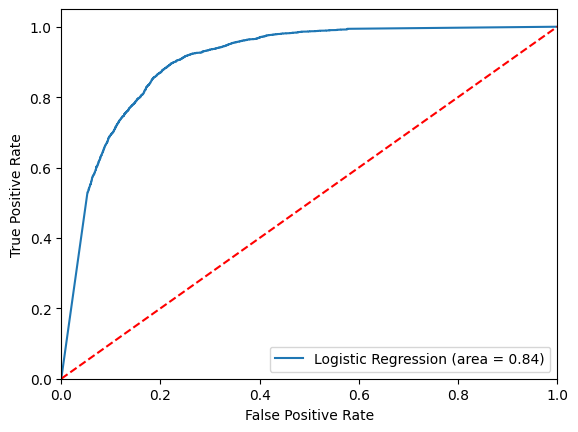

In [13]:
y_pred = knn_grid_search.predict(X_test)
y_pred_proba = knn_grid_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 4. DecisionTree

### 4.a Simple DecisionTree

In [40]:
# instanciemos el modelo y entremoslo en el conjunto de autos
arbol = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=1, min_samples_split=2, ccp_alpha=0)
arbol.fit(X_train,y_train)

y_pred = arbol.predict(X_test)
print_performance(y_test, y_pred)

Accuracy: 0.432068
Precision: 0.161885
Recall: 0.694092
F1 score: 0.262538
AUC: 0.540746


In [ ]:
# calculando las 5 feature importances mas altas
importances = pd.Series(arbol.feature_importances_).sort_values(ascending=False)[:15]

In [ ]:
f5_names = list(pd.Series(X_train.feature_names)[importances.index.to_list()])
fig, ax = plt.subplots()
importances.plot.barh(ax=ax)
ax.set_yticklabels(f5_names)
ax.invert_yaxis()

### 4.b DecisionTree hyperparameter opt

In [39]:
dt_parameters = {
    'max_depth' : [1, 2, 3, 10, 30, 100],
    'min_samples_split':list(range(2, 40)),
    'min_samples_leaf':list(range(2, 40)),
    'max_features':['None','auto', 'sqrt', 'log2'],
    'max_leaf_nodes':list(range(10, 60))
}

n_iter = 40
cv = 3

dt_tree = DecisionTreeClassifier()

dt_grid_search = RandomizedSearchCV(estimator=dt_tree, 
                                         param_distributions=dt_parameters, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

dt_grid_search.fit(X_train, y_train)

In [48]:
# This suggests overfitting
print('train accuracy:',dt_grid_search.best_score_, dt_grid_search.best_params_, '\n')

y_pred = dt_grid_search.predict(X_test)
print_performance(y_test, y_pred)

train accuracy: 0.6404130390767362 {'min_samples_split': 19, 'min_samples_leaf': 12, 'max_leaf_nodes': 39, 'max_features': 'auto', 'max_depth': 15} 

Accuracy: 0.471436
Precision: 0.188865
Recall: 0.797950
F1 score: 0.305437
AUC: 0.606862


## 5. RandomForestClassifier

### 5.a Simple RandomForestClassifier

Accuracy: 0.902247
Precision: 0.601872
Recall: 0.971405
F1 score: 0.743240
AUC: 0.930932


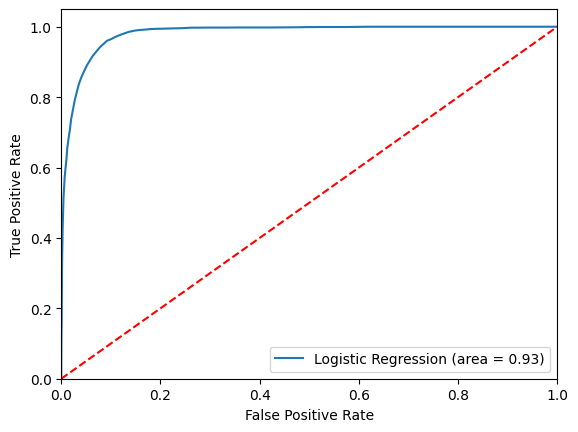

In [27]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train,y_train)

y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 5.b RandomForestClassifier hyperparameter opt

In [10]:
rf_parameters = {
    'n_estimators':range(10,500),
    'criterion':['gini', 'entropy', 'log_loss'],
    'max_depth' : [30, 100, 150, 250, 350, 550],
    'min_samples_split':list(range(2, 40)),
    'min_samples_leaf':list(range(2, 40)),
    'max_features':['None','auto', 'sqrt', 'log2'],
    # 'max_leaf_nodes':list(range(10, 100))
}

n_iter = 100
cv = 3

rf_tree = RandomForestClassifier()

rf_randomized_search = RandomizedSearchCV(estimator=rf_tree, 
                                         param_distributions=rf_parameters, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

rf_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 700 candidates, totalling 2100 fits


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
618 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
113 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 341, in fit
    self._validate_params()
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\base.py", line 570, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Felipe\miniconda3\li

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=700,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [30, 100, 150, 250, 350,
                                                      550],
                                        'max_features': ['None', 'auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10, 11, 12,
                                                             13, 14, 15, 16, 17,
                                                             18, 19, 20, 21, 22,
                                                             23, 24, 25, 26, 27,
                                                             28, 29, 30, 31, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...],
                                        'n_estimators': range(10, 500)},
                   scoring='accuracy', verbose=2)

train accuracy: 0.900688398461227 {'n_estimators': 296, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'criterion': 'gini'} 

Accuracy: 0.893722
Precision: 0.581042
Recall: 0.968978
F1 score: 0.726464
AUC: 0.924935


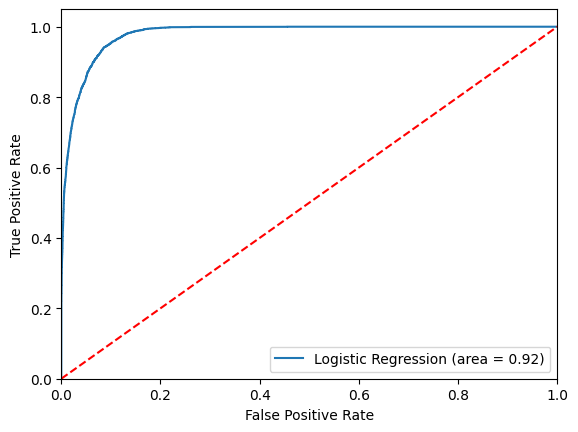

In [11]:
# This suggests overfitting
print('train accuracy:',rf_randomized_search.best_score_, rf_randomized_search.best_params_, '\n')

y_pred = rf_randomized_search.predict(X_test)
y_pred_proba = rf_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 6. Bagging

### 6.a Simple Bagging ExtraTrees

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.882603
Precision: 0.556730
Recall: 0.951713
F1 score: 0.702509
AUC: 0.911267


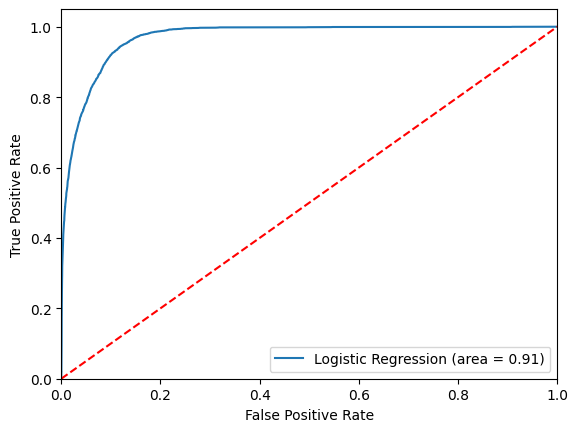

In [11]:
dt_bagging = BaggingClassifier(ExtraTreesClassifier())

dt_bagging.fit(X_train,y_train)

y_pred = dt_bagging.predict(X_test)
y_pred_proba = dt_bagging.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 6.b Bagging ExtraTrees Hyperparameter Opt

In [ ]:
bagging_parameter = {
    'estimator__max_depth' : [1, 2, 3, 10, 30, 100],
    'estimator__min_samples_split':list(range(2, 40)),
    'estimator__min_samples_leaf':list(range(2, 40)),
    'estimator__max_features':['None','auto', 'sqrt', 'log2'],
    'estimator__max_leaf_nodes':list(range(10, 60)),
    
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators':[5, 10, 20, 40, 100],
    'max_features':[0.1,0.25,0.5,0.75,0.99]
}

In [28]:
n_iter = 50
cv = 3

bagging_tree = BaggingClassifier(DecisionTreeClassifier())

bagging_dt_randomized_search = RandomizedSearchCV(estimator=bagging_tree, 
                                         param_distributions=bagging_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=-1, verbose=100)

bagging_dt_randomized_search.fit(X_train, y_train)

NameError: name 'bagging_parameter' is not defined

train accuracy: 0.6085914827562934 {'n_estimators': 5, 'max_samples': 0.1, 'max_features': 0.1} 

Accuracy: 0.642150
Precision: 0.235063
Recall: 0.646345
F1 score: 0.344748
AUC: 0.643890


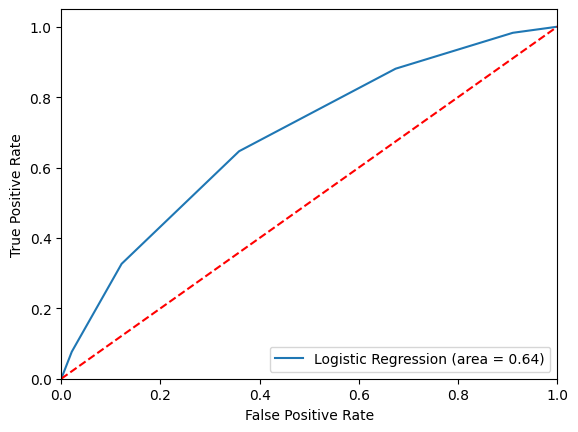

In [16]:
print('train accuracy:',bagging_dt_randomized_search.best_score_, bagging_dt_randomized_search.best_params_, '\n')

y_pred = bagging_dt_randomized_search.predict(X_test)
y_pred_proba = bagging_dt_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 6.b Simple Bagging RandomForest

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.877731
Precision: 0.545903
Recall: 0.954411
F1 score: 0.694543
AUC: 0.909535


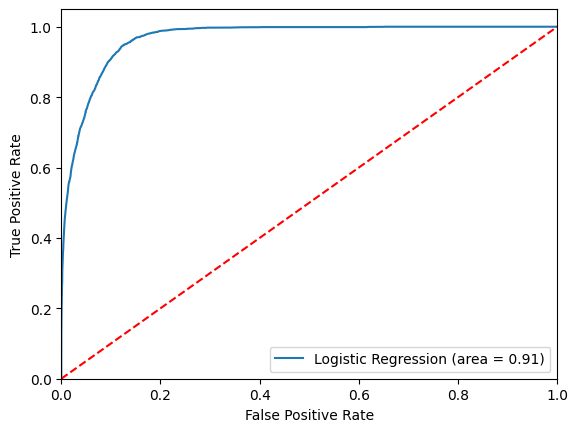

In [13]:
bagging_rf = BaggingClassifier(RandomForestClassifier())

bagging_rf.fit(X_train,y_train)

Accuracy: 0.877731
Precision: 0.545903
Recall: 0.954411
F1 score: 0.694543
AUC: 0.909535


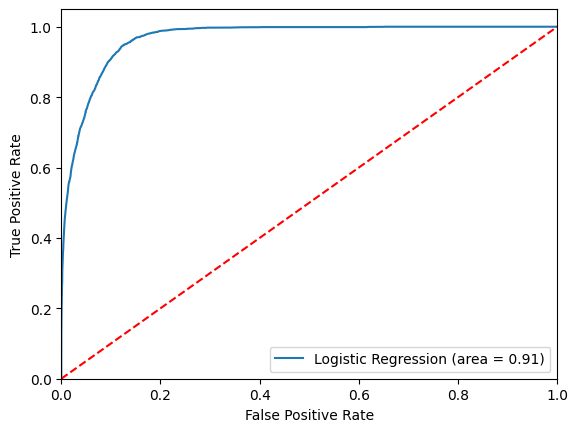

In [15]:
y_pred = bagging_rf.predict(X_test)
y_pred_proba = bagging_rf.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 6.b Bagging RandomForest Hyperparameter Opt

In [ ]:
bagging_parameter = {
    'estimator__max_depth' : [1, 2, 3, 10, 30, 100],
    'estimator__min_samples_split':list(range(2, 40)),
    'estimator__min_samples_leaf':list(range(2, 40)),
    'estimator__max_features':['None','auto', 'sqrt', 'log2'],
    'estimator__max_leaf_nodes':list(range(10, 60)),
    
    'max_samples' : [0.05, 0.1, 0.2, 0.5],
    'n_estimators':[5, 10, 20, 40, 100],
    'max_features':[0.1,0.25,0.5,0.75,0.99]
}

In [ ]:
n_iter = 50
cv = 3

bagging_random_forest = BaggingClassifier(RandomForestClassifier())

bagging_rf_randomized_search = RandomizedSearchCV(estimator=bagging_random_forest, 
                                         param_distributions=bagging_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=-1, verbose=100)

bagging_rf_randomized_search.fit(X_train, y_train)

In [ ]:
print('train accuracy:',bagging_rf_randomized_search.best_score_, bagging_rf_randomized_search.best_params_, '\n')

y_pred = bagging_rf_randomized_search.predict(X_test)
y_pred_proba = bagging_rf_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 7. ExtraTrees

### 7.a Simple ExtraTrees

In [26]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train,y_train)

C:\Users\Felipe\AppData\Local\Temp\ipykernel_18732\636858048.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_trees.fit(X_train,y_train)


ExtraTreesClassifier()

Accuracy: 0.914388
Precision: 0.634365
Recall: 0.973024
F1 score: 0.768019
AUC: 0.938708


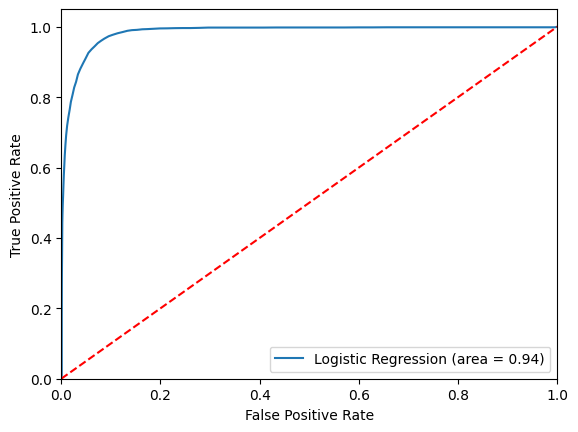

In [29]:
y_pred = extra_trees.predict(X_test)
y_pred_proba = extra_trees.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 7.b ExtraTrees hyperparameter opt

In [15]:
extra_trees_parameter = {
    'n_estimators': [10, 20, 50, 100, 200, 500, 1000, 1200, 1500, 1800, 1900, 2000, 2100, 3000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 8, 13, 21, 34, 53, 54, 55, 89, None],
    'min_samples_split': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
    'min_samples_leaf': [1, 2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377],
    # 'min_weight_fraction_leaf': [x / 10 for x in range(0, 6)],
    'max_features': ['auto', 'sqrt', 'log2', 2, 5, 8, 13, 21, 34, None],
    'max_leaf_nodes': [2, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, None],
    'min_impurity_decrease': [x / 100 for x in range(0, 11)],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'warm_start': [True, False],
    #'class_weight': ['balanced', 'balanced_subsample', None],
    'n_estimators': range(1800, 2100, 10),
    
}

In [16]:
n_iter = 500
cv = 3

extra_trees = ExtraTreesClassifier()

extra_trees_randomized_search = RandomizedSearchCV(estimator=extra_trees, 
                                         param_distributions=extra_trees_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

extra_trees_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 5, 8, 13, 21, 34,
                                                      53, 54, 55, 89, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         2, 5, 8, 13, 21, 34,
                                                         None],
                                        'max_leaf_nodes': [2, 5, 8, 13, 21, 34,
                                                           55, 89, 144, 233,
                                                           377, None],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.02, 0.03,
                                                                  0.04, 0.05,
                                                                  0.06, 0.07,
                                                                  0.08, 0.09,
                                                                  0.1],
                                        'min_samples_leaf': [1, 2, 5, 8, 13, 21,
                                                             34, 55, 89, 144,
                                                             233, 377],
                                        'min_samples_split': [2, 5, 8, 13, 21,
                                                              34, 55, 89, 144,
                                                              233, 377],
                                        'n_estimators': range(1800, 2100, 10),
                                        'oob_score': [True, False],
                                        'warm_start': [True, False]},
                   scoring='accuracy', verbose=100)

Accuracy: 0.839895
Precision: 0.471883
Recall: 0.833019
F1 score: 0.602478
AUC: 0.837043


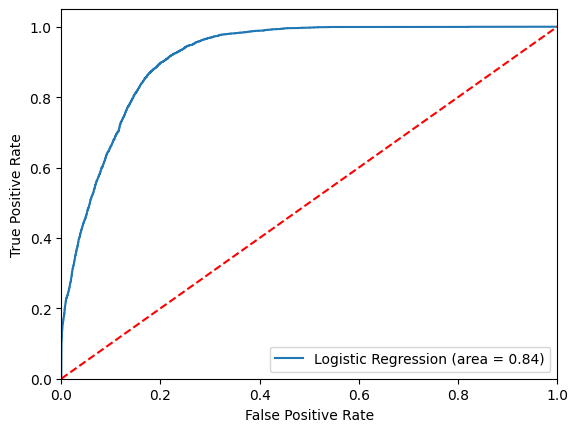

In [23]:
y_pred = extra_trees_randomized_search.predict(X_test)
y_pred_proba = extra_trees_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 8. AdaBoost

### 8.a Simple AdaBoost

In [25]:
adaboost_cls = AdaBoostClassifier(base_estimator=ExtraTreesClassifier(random_state=semilla), n_estimators=100)

adaboost_cls.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=ExtraTreesClassifier(random_state=2023),
                   n_estimators=100)

Accuracy: 0.909673
Precision: 0.621673
Recall: 0.970326
F1 score: 0.757822
AUC: 0.934830


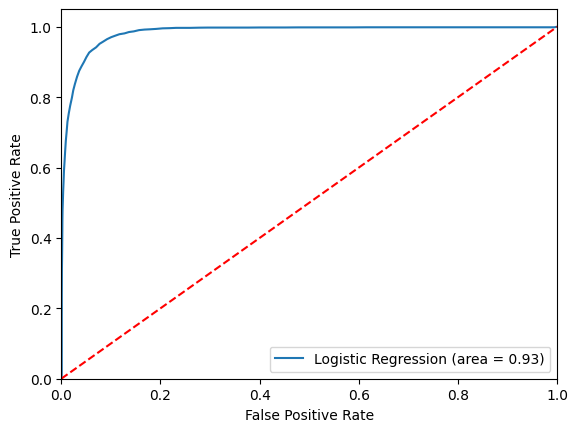

In [26]:
y_pred = adaboost_cls.predict(X_test)
y_pred_proba = adaboost_cls.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 9. GradientBoosting

### 9.a Simple GradientBoosting

In [23]:
grad_boost_cls = GradientBoostingClassifier()

grad_boost_cls.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier()

Accuracy: 0.717586
Precision: 0.312547
Recall: 0.782843
F1 score: 0.446736
AUC: 0.744652


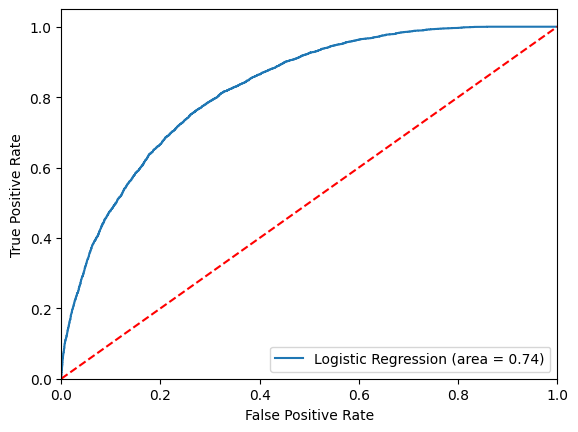

In [24]:
y_pred = grad_boost_cls.predict(X_test)
y_pred_proba = grad_boost_cls.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 9. XGBoost

### 9.a Simple XGBoost

In [36]:
xgb = XGBClassifier(n_jobs=3, eval_metric="logloss", use_label_encoder=False)
xgb.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=3,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

Accuracy: 0.899419
Precision: 0.595887
Recall: 0.961424
F1 score: 0.735756
AUC: 0.925136


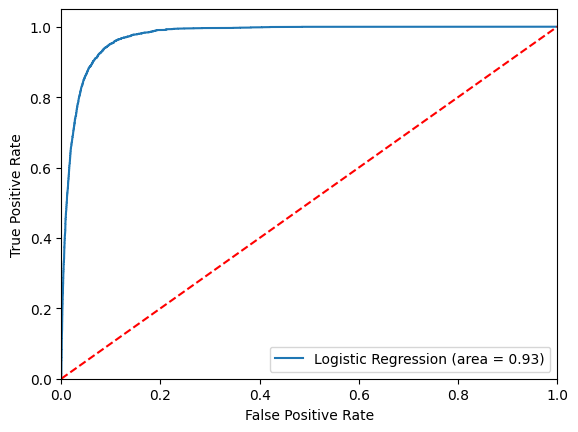

In [37]:
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

### 9.b XGBooost Hyperparameter opt

In [10]:
xgboost_parameter = {
    'max_depth':list(range(3,15))+[None],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': range(1, 10, 1),
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

In [13]:
n_iter = 100
cv = 3

xgb = XGBClassifier(n_jobs=-1)

xgb_randomized_search = RandomizedSearchCV(estimator=xgb, 
                                         param_distributions=xgboost_parameter, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)

xgb_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
99 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\sklearn.py", line 1490, in fit
    self._Booster = train(
  File "c:\Users\Felipe\miniconda3\lib\site-packages\xgboost\core.py"

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0],
                                        'gamma': [0, 0.5, 1],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          0.5, 0.7],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14, None],
                                        'min_child_weight': range(1, 10),
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [0.5, 1, 5],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   scoring='accuracy', verbose=2)

Accuracy: 0.960042
Precision: 0.787270
Recall: 0.994335
F1 score: 0.878770
AUC: 0.974266


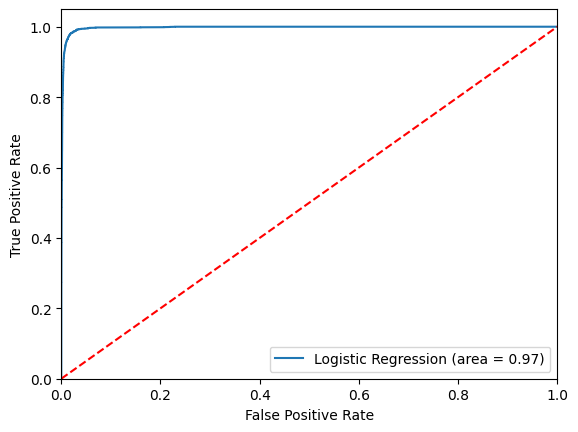

In [14]:
y_pred = xgb_randomized_search.predict(X_test)
y_pred_proba = xgb_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

In [20]:
save_model(xgb_randomized_search, 'xgb_randomized_search.sav')

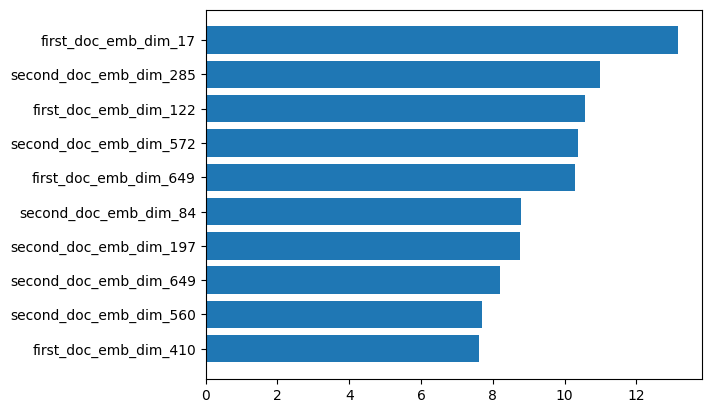

In [52]:
importance = xgb_cls.best_estimator_.get_booster().get_score(importance_type='gain') # Importance: gain
sorted_importance = dict(sorted(importance.items(), key=lambda x: x[1], reverse=True)) # Sort by descending importance

top_n = dict(list(sorted_importance.items())[:10]) # Keep top N

# Plot
plt.barh(range(len(top_n)), list(top_n.values())[::-1], align='center')
plt.yticks(range(len(top_n)), list(top_n.keys())[::-1])
plt.show()

## 10. LightGBM

### 10.a Simple LightGBM

In [39]:
lgbm = LGBMClassifier(n_jobs=3, verbose=-1)
lgbm.fit(X_train,y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(n_jobs=3, verbose=-1)

Accuracy: 0.850385
Precision: 0.492938
Recall: 0.950904
F1 score: 0.649291
AUC: 0.892076


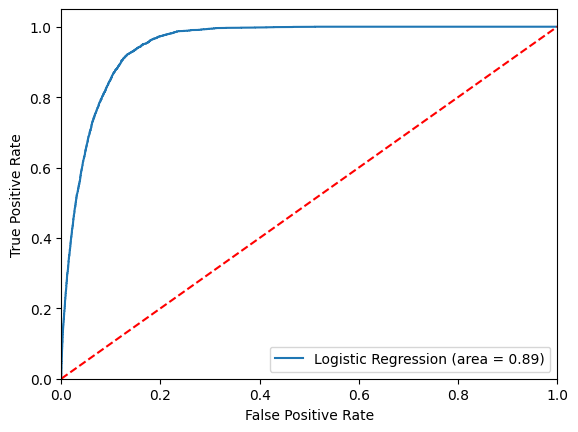

In [40]:
y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 11. CatBoost

### 11.a Simple CatBoost

In [41]:
catb = CatBoostClassifier(thread_count=3, verbose=False)
catb.fit(X_train,y_train)

Accuracy: 0.901501
Precision: 0.600402
Recall: 0.967899
F1 score: 0.741093
AUC: 0.929040


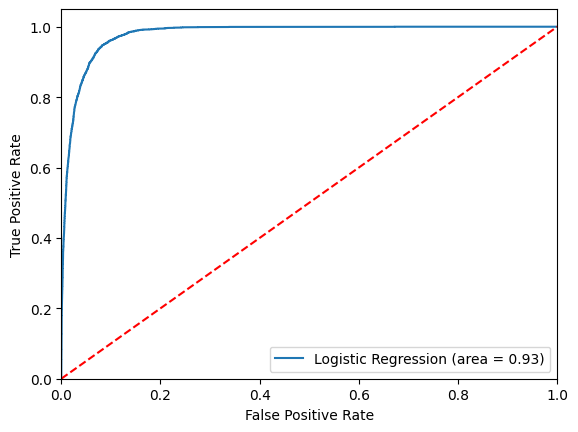

In [42]:
y_pred = catb.predict(X_test)
y_pred_proba = catb.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 11.b CatBoost hyperparameter opt

In [12]:
catb_parameters = {
    'iterations': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
    'depth': range(3, 15, 1),
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 96, 128, 160],
    'bagging_temperature': [0, 0.1, 0.5, 1, 2, 5],
    'random_strength': [0, 0.1, 0.5, 1, 2, 5],
    'auto_class_weights': ['None', 'Balanced', 'SqrtBalanced'],
    'leaf_estimation_method': ['Newton', 'Gradient', 'Exact'],
    'eval_metric': ['Logloss', 'AUC', 'F1', 'Accuracy', 'Precision', 'Recall']
}


In [13]:
n_iter = 100
cv = 3

catb = CatBoostClassifier()

catb_randomized_search = RandomizedSearchCV(estimator= catb, 
                                         param_distributions= catb_parameters, n_iter=n_iter, cv=cv, scoring='accuracy', n_jobs=None, verbose=2)

catb_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END auto_class_weights=None, bagging_temperature=1, border_count=128, depth=10, eval_metric=F1, iterations=700, l2_leaf_reg=7, leaf_estimation_method=Exact, learning_rate=0.1, random_strength=0.5; total time=   0.1s
[CV] END auto_class_weights=None, bagging_temperature=1, border_count=128, depth=10, eval_metric=F1, iterations=700, l2_leaf_reg=7, leaf_estimation_method=Exact, learning_rate=0.1, random_strength=0.5; total time=   1.0s
[CV] END auto_class_weights=None, bagging_temperature=1, border_count=128, depth=10, eval_metric=F1, iterations=700, l2_leaf_reg=7, leaf_estimation_method=Exact, learning_rate=0.1, random_strength=0.5; total time=   0.0s
[CV] END auto_class_weights=None, bagging_temperature=5, border_count=96, depth=3, eval_metric=Logloss, iterations=900, l2_leaf_reg=1, leaf_estimation_method=Exact, learning_rate=0.1, random_strength=0; total time=   0.0s
[CV] END auto_class_weights=None, bagging_temperatur

KeyboardInterrupt: 

In [ ]:
y_pred = catb_randomized_search.predict(X_test)
y_pred_proba = catb_randomized_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

NameError: name 'catb_randomized_search' is not defined

# Evaluating the model for each desafio

In [13]:
# Partición en train y test
y = df_predic_scaled.loc[:, df_predic_scaled.columns == 'target']['target'].values.tolist()
X = df_predic_scaled.loc[:, df_predic_scaled.columns != 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)


Desafio: 15
Accuracy: 0.974530
Precision: 0.868957
Recall: 0.994178
F1 score: 0.927359
AUC: 0.982433


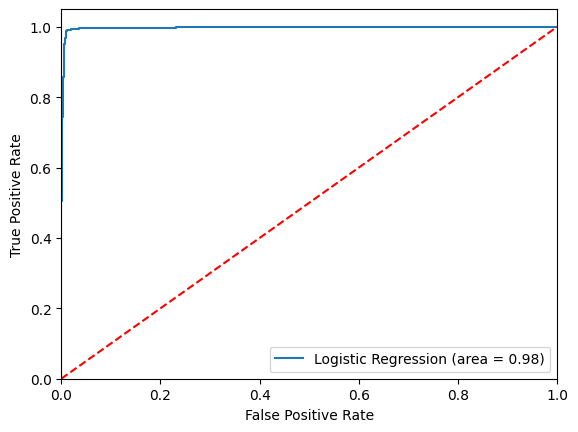


Desafio: 13
Accuracy: 0.966271
Precision: 0.853568
Recall: 0.998915
F1 score: 0.920540
AUC: 0.978624


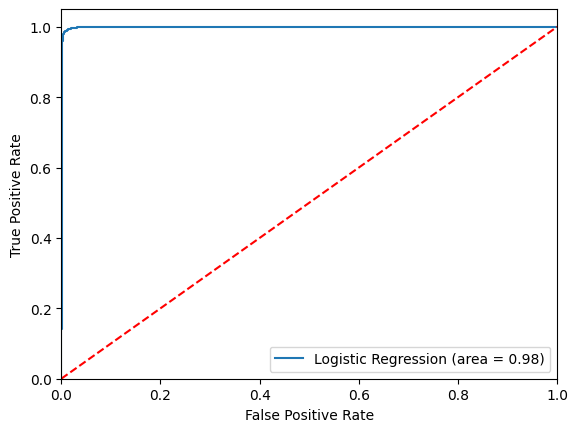


Desafio: 14
Accuracy: 0.991778
Precision: 0.937500
Recall: 0.997625
F1 score: 0.966628
AUC: 0.994305


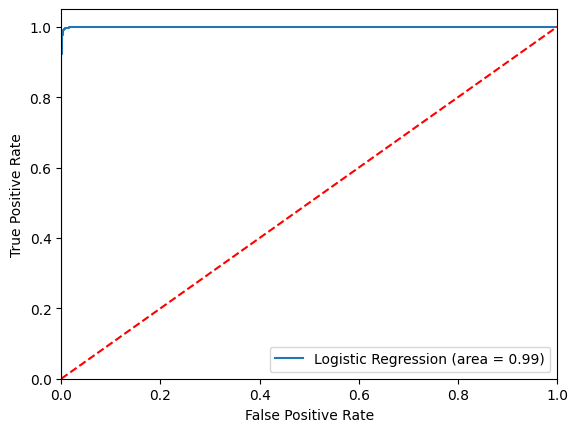


Desafio: 12
Accuracy: 0.933014
Precision: 0.661829
Recall: 0.989154
F1 score: 0.793043
AUC: 0.956899


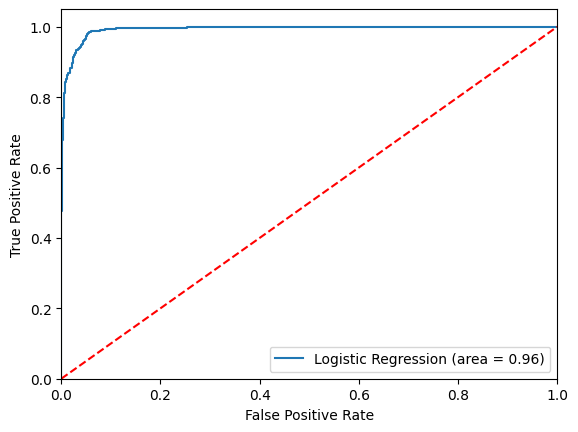


Desafio: 16
Accuracy: 0.961609
Precision: 0.804775
Recall: 0.987931
F1 score: 0.886997
AUC: 0.972402


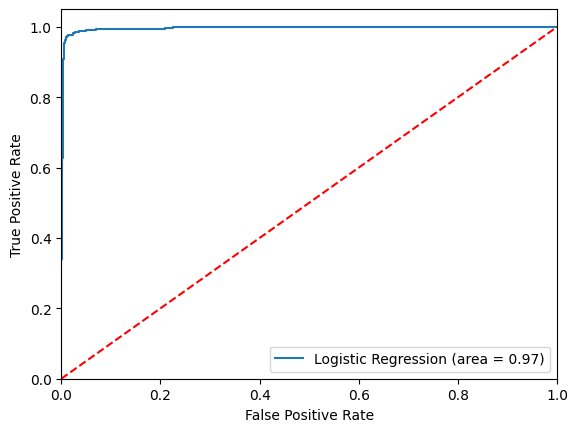


Desafio: 17
Accuracy: 0.949730
Precision: 0.676087
Recall: 1.000000
F1 score: 0.806744
AUC: 0.971919


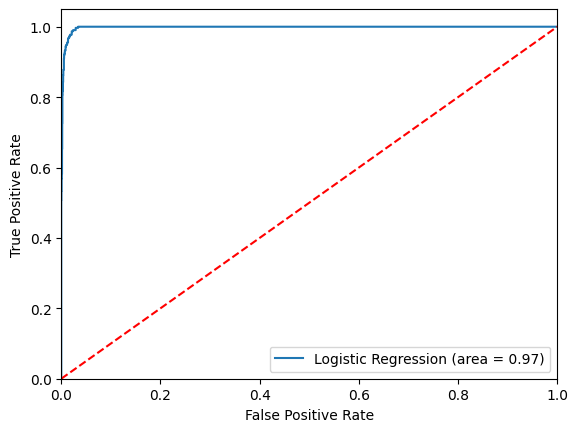


Desafio: 18
Accuracy: 0.929740
Precision: 0.633858
Recall: 0.990769
F1 score: 0.773109
AUC: 0.956061


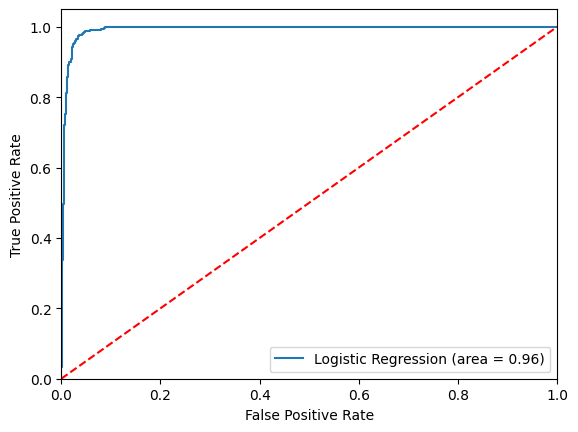

In [14]:
for des in df.desafio.unique():
    
    print(f'\nDesafio: {des}')
    
    indices_des = [i for i,x in enumerate(X_test['id_pairs'].values) if x[0] in df[df['desafio']==des]['ID'].values]

    X_test_des = X_test.iloc[indices_des].drop('id_pairs', axis=1)

    y_test_des = [x for i,x in enumerate(y_test) if i in indices_des]
    
    y_pred = xgb_cls.predict(X_test_des)
    y_pred_proba = xgb_cls.predict_proba(X_test_des)
    print_performance(y_test_des, y_pred, y_pred_proba)